In [1]:
import torch 
import torch.nn as nn
# import torch.nn.init as init
import matplotlib.pyplot as plt
import time
import torch.optim as optim
import torch.utils.data as data

import sys
import numpy as np
from scipy.stats import levy_stable
import datetime
from torch.utils.checkpoint import checkpoint

from scipy import optimize
from scipy import integrate


%load_ext autoreload
%autoreload 2

In [2]:
# notebook parameters
random_seed = 1
step_size = 1e-1  # 5e-2 # step size
n_pts = 5000      # number of points (one-dim)
alpha = 1.5

n_x=5 #number of different x

n_totlal = n_pts * n_x

#n_layers = 2
n_hidden_dim = 25

n_input_dim = 2
n_output_dim = 2 

BATCH_SIZE = 512



def setup_seed(seed):
    torch.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    # random.seed(seed)
    #torch.backends.cudnn.deterministic = True

In [3]:
# added: data generation 
setup_seed(random_seed)
class SDEIntegrators:
    """
    Implements the common Euler-Maruyama
    scheme used in integration of SDE.
    """

    def __init__(self):
        pass

    
    @staticmethod
    def euler_maruyama(xn, h, _f_sigma, rng):

        #np.random.seed(random_seed)
        dL = levy_stable.rvs(alpha=alpha, beta=0, size=xn.shape, scale=h**(1/alpha))    # added for levy 
        
        xk = xn.reshape(1, -1)  # we only allow a single point as input

        fk, sk = _f_sigma(xk)
        if np.prod(sk.shape) == xk.shape[-1]:
            skL = sk * dL  
        else:
            sk = sk.reshape(xk.shape[-1], xk.shape[-1])
            skL = ((sk @ dL.T).T)
        return xk + h * fk + skL   # added for levy 

    
def sample_data(drift_diffusivity, step_size, n_dimensions, low, high, n_pts, rng, n_subsample=1):

    x0 = np.linspace(low, high, n_x+1)
    x1 = np.tile(np.repeat(x0[:-1], n_pts/n_x), n_x)
    x2 = np.repeat(x0[:-1], n_pts)
    x_data = np.concatenate((x1.reshape(-1, 1),x2.reshape(-1, 1)),1)
    y_data = x_data.copy()
    for k in range(n_subsample):
        y_data = np.row_stack([
            SDEIntegrators.euler_maruyama(y_data[k, :],
                                          step_size / n_subsample,
                                          drift_diffusivity,
                                          rng)
            for k in range(x_data.shape[0])
        ])

    return x_data, y_data


# EXAMPLE 1
def true_drift(x):
    return np.hstack(((x[:,0]+x[:,1]).reshape(-1,1),(4*x[:,0]-2*x[:,1]).reshape(-1,1)))


def true_diffusivity(x):
    return np.hstack(((0.5*x[:,1]+1).reshape(-1,1),(0.5*x[:,0]+1).reshape(-1,1)))


def true_drift_diffusivity(x):
    return true_drift(x), true_diffusivity(x)


rng = np.random.default_rng(random_seed)

x_data, y_data = sample_data(true_drift_diffusivity,
                             step_size=step_size, n_dimensions=n_input_dim,
                             low=-1, high=1, n_pts=n_pts,
                             rng=rng)
print('data shape', x_data.shape, y_data.shape)

# print(x_data, y_data)

data shape (25000, 2) (25000, 2)


In [4]:
#trick

y_mean = np.array([])
y_median = np.array([])
x_mean = np.array([])
for i in range(n_x*n_x):
    yi_mean = np.mean(y_data[(i*np.int(n_pts/n_x)):((i+1)*np.int(n_pts/n_x)),:], 0)
    yi_median = np.median(y_data[(i*np.int(n_pts/n_x)):((i+1)*np.int(n_pts/n_x)),:], 0)
    xi_mean = x_data[i*np.int(n_pts/n_x),:]
    y_mean = np.append(y_mean, yi_mean)
    y_median = np.append(y_median, yi_median)
    x_mean = np.append(x_mean, xi_mean)

y_mean = y_mean.reshape(-1,2)
y_median = y_median.reshape(-1,2)
x_mean = x_mean.reshape(-1,2)
# print(y_mean, y_median, x_mean)

In [5]:

#20% statistics

y_mean2 = np.array([])
#####
for i in range(n_x * n_x):
    yi_mean1 = np.mean(np.sort(y_data[:, 0].ravel()[(i*np.int(n_pts/n_x)):((i+1)*np.int(n_pts/n_x))])[400:600]) ##
    yi_mean2 = np.mean(np.sort(y_data[:, 1].ravel()[(i*np.int(n_pts/n_x)):((i+1)*np.int(n_pts/n_x))])[400:600])
    yi_mean = np.array([yi_mean1, yi_mean2])
    y_mean2 = np.append(y_mean2, yi_mean)
    
y_mean2 = y_mean2.reshape(-1,2)
# print(y_mean2)

In [6]:
#network initialization
small_init=1e-2
def weight_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias,0.1)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight.data,-small_init,small_init)
        nn.init.uniform_(m.bias,-small_init,small_init)

In [7]:
#neural network structure
class FCNN1(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim):
        super(FCNN1,self).__init__()
        self.hidden1 = nn.Linear(in_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.predict = nn.Linear(hidden_dim, out_dim)
    def forward(self,input):
        out = self.hidden1(input)
        out = torch.nn.functional.elu(out)
        out = self.hidden2(out)
        out = torch.nn.functional.elu(out)
        out = self.hidden3(out)
        out = torch.nn.functional.elu(out)
        out = self.predict(out)

        return out
    
class FCNN2(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim):
        super(FCNN2,self).__init__()
        self.hidden1 = nn.Linear(in_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.predict = nn.Linear(hidden_dim, out_dim)
    def forward(self,input):
        out = self.hidden1(input)
        out = torch.nn.functional.elu(out)
        out = self.hidden2(out)
        out = torch.nn.functional.elu(out)
        out = self.predict(out)
        out = torch.nn.functional.softplus(out) + torch.tensor([1e-13])

        return out



In [8]:
# ms_model = FCNN(n_input_dim, n_output_dim, n_hidden_dim)
mean_model = FCNN1(n_input_dim, n_output_dim, n_hidden_dim)
std_model = FCNN2(int(n_input_dim/2), int(n_output_dim/2), n_hidden_dim)
std_model2 = FCNN2(int(n_input_dim/2), int(n_output_dim/2), n_hidden_dim)

# weight_init(ms_model)
weight_init(std_model)
# weight_init(std_model2)

# optimizer = optim.Adamax(ms_model.parameters(), lr=0.005,eps=1e-07)
optimizer1 = optim.Adam(mean_model.parameters(), lr=0.005)
optimizer2 = optim.Adamax(std_model.parameters(),lr=0.005, eps=1e-07)
optimizer3 = optim.Adamax(std_model2.parameters(),lr=0.005, eps=1e-07)
#optimizer2 = optim.Adamax(std_model.parameters(),lr=0.001, eps=1e-07)
#mean_model,std_model

In [9]:
#S0(alpha,beta,sigmma,gamma),beta=0,sigmma=1,gamma=0 in numpy
import math
def pdf_zolotarev(x, alpha=alpha):
    """Calculate pdf using Zolotarev's methods as detailed in [BS].
    """
    
    if alpha != 1:
        x0 = x   # convert to S_0 parameterization
        
        def V(theta):
            return (np.cos(theta)/np.sin(alpha*theta))**(alpha/(alpha-1)) * \
                    (np.cos((alpha-1)*theta)/np.cos(theta))
        if x0 > 0:
            def g(theta):
                return (V(theta) *
                        np.real(np.complex128(x0)**(alpha/(alpha-1))))

            def f(theta):
                return g(theta) * np.exp(-g(theta))

            # spare calculating integral on null set
            # use isclose as macos has fp differences

            with np.errstate(all="ignore"):
                intg_max = optimize.minimize_scalar(lambda theta: -f(theta), bounds=[0, np.pi/2])
                intg_kwargs = {}
                # windows quadpack less forgiving with points out of bounds
                if intg_max.success and not np.isnan(intg_max.fun)\
                        and intg_max.x > 0 and intg_max.x < np.pi/2:
                    intg_kwargs["points"] = [intg_max.x]
                intg = integrate.quad(f, 0, np.pi/2, **intg_kwargs)[0]
                return alpha * intg / np.pi / np.abs(alpha-1) / x0
        elif x0 == 0:
            return math.gamma(1+1/alpha)/np.pi
        else:
            return pdf_zolotarev(-x, alpha)
r=pdf_zolotarev(1);r

0.20203815960784008

In [10]:
#S0(alpha,beta,sigmma,gamma),beta=0,sigmma=1,gamma=0 in torch
import math
def pdf_zolotarev2(x0, alpha=alpha):
    """Calculate pdf using Zolotarev's methods as detailed in [BS].
    """
    small_value = torch.Tensor([1e-8])
    
    if alpha != 1:
        #x0 = x   # convert to S_0 parameterization
        #x0 = torch.tensor([x], dtype=torch.float32, requires_grad=True)
        def V(theta):
            if alpha > 1:
                if torch.sin(alpha*theta) == 0 or torch.cos(theta) == 0:
                    return (torch.cos(theta)/(torch.sin(alpha*theta) + small_value))**(alpha/(alpha-1)) * \
                            (torch.cos((alpha-1)*theta)/(torch.cos(theta) + small_value))
                else:
                    return (torch.cos(theta)/torch.sin(alpha*theta))**(alpha/(alpha-1)) * \
                            (torch.cos((alpha-1)*theta)/torch.cos(theta))
            else:
                if theta == torch.tensor([np.pi/2]):
                    return ((torch.cos(theta)+small_value)/torch.sin(alpha*theta))**(alpha/(alpha-1)) * \
                            (torch.cos((alpha-1)*theta)/(torch.cos(theta)+small_value))
                else:
                    return (torch.cos(theta)/torch.sin(alpha*theta))**(alpha/(alpha-1)) * \
                            (torch.cos((alpha-1)*theta)/torch.cos(theta))
        if x0 > 0:
            def g(theta):
                return (V(theta) * x0 **(alpha/(alpha-1)))
#                         torch.real(torch.complex(x0,torch.Tensor([0.]))**(alpha/(alpha-1))))

            def f(theta):
                return g(theta) * torch.exp(-g(theta))

            # spare calculating integral on null set
            # use isclose as macos has fp differences
            intg_n = 100 
            theta = torch.linspace(0., np.pi/2, intg_n+1)
            ff = torch.zeros_like(theta, dtype=torch.float32)
            for i in range(theta.shape[0]):
                ff[i] = f(theta[i])
        
#             fnotnan = ff>=0
#             fnan =~fnotnan
#             ff = torch.where(fnan, torch.zeros_like(ff,dtype=torch.float32), ff)
            intg = 0
            for i in range(intg_n):
                intg += (ff[i + 1] + ff[i]) * (theta[1] - theta[0]) / 2

            
            return alpha * intg / np.pi / np.abs((alpha-1))/ x0
        elif x0 == 0:
            return torch.Tensor([math.gamma(1+1/alpha)/np.pi]) + 0*x0
        else:
            return pdf_zolotarev2(-x0, alpha)
        
t=torch.tensor([1.],requires_grad=True)
r=pdf_zolotarev2(t);r.backward()
print(r,t.grad)
#r=pdf_zolotarev2(69814);r

tensor([0.2020], grad_fn=<DivBackward0>) tensor([-0.1356])


In [11]:
#S_alpha(h**(1/alpha)*sigma(x),0,x+f(x)*h) pdf
def alpha_stable_pdf(yn, ynp1, step_size_, drift_, diffusivity_, alpha=alpha):
    
    f_alpha = torch.zeros_like(torch.Tensor(yn))
    ynp1_std = ((ynp1-yn-step_size_*drift_)/(step_size_**(1/alpha)*diffusivity_))
    for k in range(yn.shape[0]):
        f_alpha[k] = pdf_zolotarev2(ynp1_std[k])


    return f_alpha/(step_size_**(1/alpha)*diffusivity_)

In [12]:
def log_prob_loss(mean, std, step_size, x, y):
    
    y_dist = alpha_stable_pdf(x.reshape(-1,1) ,y.reshape(-1,1), step_size, mean.reshape(-1,1), std.reshape(-1,1))
    y_log_prob = -torch.log(y_dist)
    return y_log_prob


def square_loss(mean, step_size, x, y):
#     dL = levy_stable.rvs(alpha=alpha, beta=0, size=x.shape, scale=step_size**(1/alpha))
    absloss = torch.square(y - (x + mean * step_size))# + std.reshape(-1,1) * torch.Tensor(dL)))
    
    return absloss


epoch: 1 Loss: tensor(0.0403, grad_fn=<MeanBackward0>)
tensor([[ 0.0253,  0.1432],
        [ 0.0167,  0.1312],
        [ 0.0091,  0.1137],
        [ 0.0049,  0.0890],
        [ 0.0057,  0.0589],
        [ 0.0151,  0.1456],
        [ 0.0054,  0.1363],
        [-0.0023,  0.1199],
        [-0.0076,  0.0962],
        [-0.0078,  0.0666],
        [ 0.0063,  0.1447],
        [-0.0044,  0.1377],
        [-0.0121,  0.1231],
        [-0.0177,  0.1008],
        [-0.0194,  0.0731],
        [ 0.0002,  0.1397],
        [-0.0113,  0.1341],
        [-0.0192,  0.1219],
        [-0.0255,  0.1025],
        [-0.0276,  0.0774],
        [-0.0029,  0.1297],
        [-0.0147,  0.1258],
        [-0.0238,  0.1162],
        [-0.0308,  0.1014],
        [-0.0341,  0.0808]], grad_fn=<AddmmBackward>)
epoch: 2 Loss: tensor(0.0381, grad_fn=<MeanBackward0>)
tensor([[-0.0379,  0.0416],
        [-0.0515,  0.0605],
        [-0.0635,  0.0757],
        [-0.0712,  0.0846],
        [-0.0729,  0.0870],
        [-0.0377,  0.026

epoch: 79 Loss: tensor(0.0003, grad_fn=<MeanBackward0>)
tensor([[-1.8920, -2.0771],
        [-1.6489, -0.4584],
        [-1.1903,  1.4514],
        [-0.7242,  2.9975],
        [-0.4084,  3.9985],
        [-1.5074, -2.8815],
        [-1.2753, -1.3395],
        [-0.8619,  0.5637],
        [-0.3680,  2.3544],
        [-0.0562,  3.4971],
        [-1.1127, -3.6221],
        [-0.8226, -2.2356],
        [-0.4338, -0.4337],
        [ 0.0573,  1.5450],
        [ 0.3560,  2.8734],
        [-0.7908, -4.2684],
        [-0.4317, -3.0246],
        [ 0.0178, -1.4369],
        [ 0.5147,  0.5434],
        [ 0.8039,  2.1141],
        [-0.5340, -4.8265],
        [-0.1298, -3.6832],
        [ 0.3490, -2.2797],
        [ 0.8625, -0.4973],
        [ 1.2263,  1.2383]], grad_fn=<AddmmBackward>)
epoch: 80 Loss: tensor(0.0003, grad_fn=<MeanBackward0>)
tensor([[-1.8873, -2.0596],
        [-1.6463, -0.4502],
        [-1.1926,  1.4486],
        [-0.7298,  2.9905],
        [-0.4160,  3.9899],
        [-1.5021, -2.8

epoch: 164 Loss: tensor(0.0002, grad_fn=<MeanBackward0>)
tensor([[-1.9316, -1.9915],
        [-1.6419, -0.4535],
        [-1.2052,  1.3031],
        [-0.7342,  2.9985],
        [-0.4373,  4.1638],
        [-1.5298, -2.8014],
        [-1.2569, -1.2752],
        [-0.8282,  0.4690],
        [-0.3556,  2.2345],
        [-0.0687,  3.5355],
        [-1.1136, -3.5935],
        [-0.8180, -2.1249],
        [-0.3973, -0.4159],
        [ 0.0618,  1.3680],
        [ 0.3500,  2.7918],
        [-0.7665, -4.3207],
        [-0.4219, -2.9276],
        [ 0.0106, -1.2951],
        [ 0.4698,  0.4477],
        [ 0.7835,  1.9546],
        [-0.4893, -4.9632],
        [-0.1034, -3.6488],
        [ 0.3296, -2.1037],
        [ 0.7821, -0.4182],
        [ 1.1398,  1.1132]], grad_fn=<AddmmBackward>)
epoch: 165 Loss: tensor(0.0002, grad_fn=<MeanBackward0>)
tensor([[-1.9316, -1.9906],
        [-1.6416, -0.4532],
        [-1.2053,  1.3017],
        [-0.7344,  2.9983],
        [-0.4374,  4.1663],
        [-1.5298, -2

epoch: 243 Loss: tensor(0.0001, grad_fn=<MeanBackward0>)
tensor([[-1.9258, -1.9669],
        [-1.6264, -0.4421],
        [-1.2123,  1.2249],
        [-0.7589,  2.9393],
        [-0.4384,  4.3462],
        [-1.5260, -2.7715],
        [-1.2321, -1.2290],
        [-0.8166,  0.4368],
        [-0.3747,  2.1196],
        [-0.0534,  3.6039],
        [-1.1243, -3.5874],
        [-0.8114, -2.0487],
        [-0.3913, -0.3872],
        [ 0.0428,  1.2828],
        [ 0.3745,  2.7705],
        [-0.7769, -4.3857],
        [-0.4247, -2.8681],
        [ 0.0118, -1.2123],
        [ 0.4488,  0.4277],
        [ 0.7936,  1.9099],
        [-0.5001, -5.1172],
        [-0.1040, -3.6634],
        [ 0.3320, -2.0109],
        [ 0.7751, -0.3787],
        [ 1.1469,  1.0850]], grad_fn=<AddmmBackward>)
epoch: 244 Loss: tensor(0.0001, grad_fn=<MeanBackward0>)
tensor([[-1.9257, -1.9669],
        [-1.6262, -0.4420],
        [-1.2124,  1.2244],
        [-0.7593,  2.9386],
        [-0.4382,  4.3479],
        [-1.5259, -2

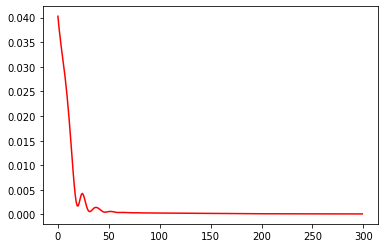

Time used: 0.8055417999999985


In [13]:
#drift
tis1 = time.perf_counter()    
epoch = 300


Loss = np.array([])

x_mean1, y_mean1 = torch.from_numpy(x_mean).float(), torch.from_numpy(y_mean2).float()
train_dataset = data.TensorDataset(x_mean1, y_mean1)


loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=1000000,
    shuffle=True
    )

for i in range(epoch):    # 对整套数据训练iterations次
    for step, (batch_x, batch_y) in enumerate(loader):
        
        optimizer1.zero_grad()
        #optimizer2.zero_grad()
        approx_mean = mean_model((batch_x))
#         approx_std = ms_model((batch_x))[:, 1]
#         log_prob = log_prob_loss(approx_mean, step_size, batch_x, batch_y)
        absloss = square_loss(approx_mean, step_size, batch_x, batch_y)
        loss = torch.mean(absloss)#+absloss)
        loss.backward()
        optimizer1.step()
        #optimizer2.step()
        Loss = np.append(Loss, loss.detach().numpy())
        torch.cuda.empty_cache()
        #print("step:", i+1, "Loss:", loss)
    print("epoch:",i+1, "Loss:", loss)
    print(mean_model(torch.Tensor(x_mean)))
    
## Plotting the loss function
q=np.arange(0,len(Loss))
plt.plot(q,Loss,'r')
plt.show()

tis2 = time.perf_counter()
print("Time used:", tis2-tis1)

In [14]:
true_f1 = np.flip(true_drift(x_mean)[:,0].reshape(n_x, n_x), axis = 0)
true_f2 = np.flip(true_drift(x_mean)[:,1].reshape(n_x, n_x), axis = 0)
print(true_f1, true_f2)

[[-4.00000000e-01  1.11022302e-16  4.00000000e-01  8.00000000e-01
   1.20000000e+00]
 [-8.00000000e-01 -4.00000000e-01  2.22044605e-16  4.00000000e-01
   8.00000000e-01]
 [-1.20000000e+00 -8.00000000e-01 -4.00000000e-01  2.22044605e-16
   4.00000000e-01]
 [-1.60000000e+00 -1.20000000e+00 -8.00000000e-01 -4.00000000e-01
   1.11022302e-16]
 [-2.00000000e+00 -1.60000000e+00 -1.20000000e+00 -8.00000000e-01
  -4.00000000e-01]] [[-5.2 -3.6 -2.  -0.4  1.2]
 [-4.4 -2.8 -1.2  0.4  2. ]
 [-3.6 -2.  -0.4  1.2  2.8]
 [-2.8 -1.2  0.4  2.   3.6]
 [-2.  -0.4  1.2  2.8  4.4]]


In [15]:

estimate_f = mean_model(torch.Tensor(x_mean)).detach().numpy()

estimate_f1 = np.flip(estimate_f[:,0].reshape(n_x, n_x), axis = 0)
estimate_f2 = np.flip(estimate_f[:,1].reshape(n_x, n_x), axis = 0)


In [16]:
import pandas as pd
import seaborn as sns


df11 = pd.DataFrame(np.round(true_f1, decimals=2),columns = [x for x in np.round(np.linspace(-1, 1, n_x+1)[:-1], decimals=2)], index = [x for x in np.round(np.linspace(1, -1, n_x+1)[1:], decimals=2)])
#estimate_f1
df12 = pd.DataFrame(estimate_f1,columns = [x for x in np.round(np.linspace(-1, 1, n_x+1)[:-1], decimals=2)], index = [x for x in np.round(np.linspace(1, -1, n_x+1)[1:], decimals=2)])


df21 = pd.DataFrame(np.round(true_f2, decimals = 2),columns = [x for x in np.round(np.linspace(-1, 1, n_x+1)[:-1], decimals=2)], index = [x for x in np.round(np.linspace(1, -1, n_x+1)[1:], decimals=2)])
#estimate_f2
df22 = pd.DataFrame(estimate_f2,columns = [x for x in np.round(np.linspace(-1, 1, n_x+1)[:-1], decimals=2)], index = [x for x in np.round(np.linspace(1, -1, n_x+1)[1:], decimals=2)])



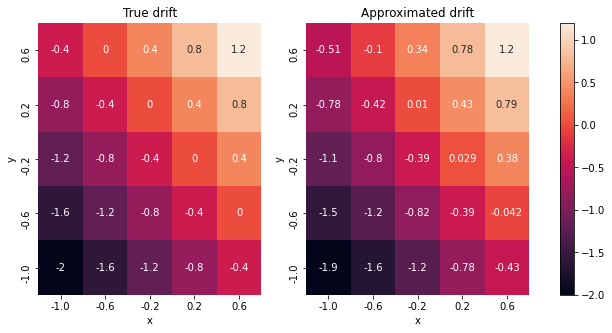

In [17]:
#drift figure1

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (11,5))

im = sns.heatmap(df11, annot=True, ax=ax1 ,cbar = False)
ax1.set_title("True drift")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
sns.heatmap(df12, annot=True, ax=ax2, cbar = False)
ax2.set_title("Approximated drift")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

mappable = im.get_children()[0]
plt.colorbar(mappable, ax = [ax1,ax2])



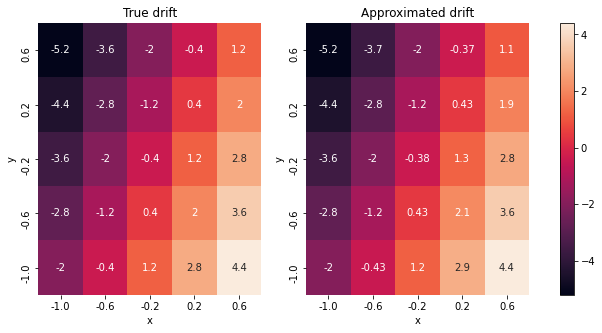

In [18]:
#drift figure2

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (11,5))

im = sns.heatmap(df21, annot=True, ax=ax1 ,cbar = False)
ax1.set_title("True drift")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
sns.heatmap(df22, annot=True, ax=ax2, cbar = False)
ax2.set_title("Approximated drift")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

mappable = im.get_children()[0]
plt.colorbar(mappable, ax = [ax1,ax2])


In [19]:
#diffusivity 1
tis1 = time.perf_counter()    
epoch = 10 #10 


Loss = np.array([])

x_data1, y_data1 = torch.from_numpy(x_data).float(), torch.from_numpy(y_data).float()
train_dataset = data.TensorDataset(x_data1, y_data1)


loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
    )

for i in range(epoch):    # 对整套数据训练iterations次
    for step, (batch_x, batch_y) in enumerate(loader):
        
#         optimizer.zero_grad()
        optimizer2.zero_grad()
#         optimizer3.zero_grad()
        approx_mean1 = mean_model((batch_x))[:, 0]
        approx_std1 = std_model(((batch_x)[:,1]).reshape(-1,1))[:, 0]
        log_prob1 = log_prob_loss(approx_mean1, approx_std1, step_size, batch_x[:,0], batch_y[:,0])
        
#         approx_mean2 = mean_model((batch_x))[:, 1]
#         approx_std2 = std_model2(((batch_x)[:,1]).reshape(-1,1))[:, 0]
#         log_prob2 = log_prob_loss(approx_mean2, approx_std2, step_size, batch_x[:,1], batch_y[:,1])
#         print(log_prob)
#         absloss = abs_loss(approx_mean, approx_std, step_size, batch_x, batch_y)
        loss = torch.mean(log_prob1)#+log_prob2)#+absloss)
        loss.backward()
        optimizer2.step()
        #optimizer3.step()
        Loss = np.append(Loss, loss.detach().numpy())
        torch.cuda.empty_cache()
        #print("step:", i+1, "Loss:", loss)
    print("epoch:",i+1, "Loss:", loss)
    print(std_model(torch.Tensor(x_data[:,1]).reshape(-1,1))[::1000])
#     print(std_model(torch.Tensor(x_data))[::1000])
    
## Plotting the loss function
q=np.arange(0,len(Loss))
plt.plot(q,Loss,'r')
plt.show()

tis2 = time.perf_counter()
print("Time used:", tis2-tis1)

KeyboardInterrupt: 

In [ ]:
estimated_std1 = std_model(torch.Tensor(x_data[:,1]).reshape(-1,1))[::1000]
estimated_std1 = estimated_std1.reshape(n_x,n_x)
# estimated_std2 = torch.load('2d_1.5_lin_lin_s2.pt')  
# print(estimated_std1,estimated_std2)

In [ ]:
#diffusivity 2
tis1 = time.perf_counter()    
epoch = 20 #18 20


Loss = np.array([])

x_data1, y_data1 = torch.from_numpy(x_data).float(), torch.from_numpy(y_data).float()
train_dataset = data.TensorDataset(x_data1, y_data1)


loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
    )

for i in range(epoch):    # 对整套数据训练iterations次
    for step, (batch_x, batch_y) in enumerate(loader):
        
#         optimizer.zero_grad()
#         optimizer2.zero_grad()
        optimizer3.zero_grad()
#         approx_mean1 = mean_model((batch_x))[:, 0]
#         approx_std1 = std_model(((batch_x)[:,0]).reshape(-1,1))[:, 0]
#         log_prob1 = log_prob_loss(approx_mean1, approx_std1, step_size, batch_x[:,0], batch_y[:,0])
        
        approx_mean2 = mean_model((batch_x))[:, 1]
        approx_std2 = std_model2(((batch_x)[:,0]).reshape(-1,1))[:, 0]
        log_prob2 = log_prob_loss(approx_mean2, approx_std2, step_size, batch_x[:,1], batch_y[:,1])
#         print(log_prob)
#         absloss = abs_loss(approx_mean, approx_std, step_size, batch_x, batch_y)
        loss = torch.mean(log_prob2)#+log_prob2)#+absloss)
        loss.backward()
#         optimizer2.step()
        optimizer3.step()
        Loss = np.append(Loss, loss.detach().numpy())
        torch.cuda.empty_cache()
        #print("step:", i+1, "Loss:", loss)
    print("epoch:",i+1, "Loss:", loss)
    print(std_model2(torch.Tensor(x_data[:,0]).reshape(-1,1))[::1000])
#     print(std_model(torch.Tensor(x_data))[::1000])
    
## Plotting the loss function
q=np.arange(0,len(Loss))
plt.plot(q,Loss,'r')
plt.show()

tis2 = time.perf_counter()
print("Time used:", tis2-tis1)

In [ ]:
estimated_std2 = std_model2(torch.Tensor(x_data[:,0]).reshape(-1,1))[::1000]
estimated_std2 = estimated_std2.reshape(n_x,n_x);estimated_std2

In [ ]:
#true_std
true_s1 = true_diffusivity(x_mean)[:,0].reshape(n_x, n_x)
true_s2 = true_diffusivity(x_mean)[:,1].reshape(n_x, n_x)
df31 = pd.DataFrame(true_s1,columns = [x for x in np.round(np.linspace(-1, 1, n_x+1)[:-1], decimals=2)], index = [x for x in np.round(np.linspace(1, -1, n_x+1)[1:], decimals=2)])
df32 = pd.DataFrame(true_s2,columns = [x for x in np.round(np.linspace(-1, 1, n_x+1)[:-1], decimals=2)], index = [x for x in np.round(np.linspace(1, -1, n_x+1)[1:], decimals=2)])

In [ ]:
#diffusivity figure1
dfs1 = pd.DataFrame(estimated_std1.detach().numpy(),columns = [x for x in np.round(np.linspace(-1, 1, n_x+1)[:-1], decimals=2)], index = [x for x in np.round(np.linspace(1, -1, n_x+1)[1:], decimals=2)])
dfs2 = pd.DataFrame(estimated_std2.detach().numpy(),columns = [x for x in np.round(np.linspace(-1, 1, n_x+1)[:-1], decimals=2)], index = [x for x in np.round(np.linspace(1, -1, n_x+1)[1:], decimals=2)])

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (11,5))

im = sns.heatmap(df31, annot=True,fmt='.2f', ax=ax1, vmin=0, vmax=2, cbar = False)
ax1.set_title("true diffusivity")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
sns.heatmap(dfs1, annot=True, fmt='.2f', ax=ax2, vmin=0, vmax=2, cbar = False)
ax2.set_title("Approximated diffusivity")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

mappable = im.get_children()[0]
plt.colorbar(mappable, ax = [ax1,ax2])


In [ ]:
#diffusivity figure2
dfs1 = pd.DataFrame(estimated_std1.detach().numpy(),columns = [x for x in np.round(np.linspace(-1, 1, n_x+1)[:-1], decimals=2)], index = [x for x in np.round(np.linspace(1, -1, n_x+1)[1:], decimals=2)])
dfs2 = pd.DataFrame(estimated_std2.detach().numpy(),columns = [x for x in np.round(np.linspace(-1, 1, n_x+1)[:-1], decimals=2)], index = [x for x in np.round(np.linspace(1, -1, n_x+1)[1:], decimals=2)])

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (11,5))

im = sns.heatmap(df32, annot=True, fmt='.2f', ax=ax1 ,vmin=0, vmax=2, cbar = False)
ax1.set_title("true diffusivity")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
sns.heatmap(dfs2, annot=True, fmt='.2f', ax=ax2, vmin=0, vmax=2, cbar = False)
ax2.set_title("Approximated diffusivity")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

mappable = im.get_children()[0]
plt.colorbar(mappable, ax = [ax1,ax2])



In [ ]:
#L2loss
L2lossf=torch.mean(torch.square(torch.tensor(estimate_f)-torch.tensor(true_drift(x_mean))))
L2lossg=torch.mean(torch.square(estimated_std1-torch.tensor(true_s1)))+torch.mean(torch.square(estimated_std2-torch.tensor(true_s2)))
print(L2lossf,L2lossg)